Chemical space of the generated molecules is visualized by t-SNE where each molecule is represented as Morgan fingerprint vectors.

A lot of molecules are used for calculating t-SNE, so the process could take some time. It took about 1 and a half hour for our machine, with CPU spec (2 of Intel Xeon Gold 6140, each having 18 cores) and 448 GB RAM.

In [1]:
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import numpy as np
import pickle
import json
from logics_pack import global_settings, analysis, chemistry, evaluation
from MulticoreTSNE import MulticoreTSNE as TSNE
import time
import matplotlib.pyplot as plt

project_paths = global_settings.build_project_paths(project_dir='../')
expset_obj = global_settings.ExperimentSettings(project_paths['EXPERIMENT_SETTINGS_JSON'])
expset_obj.get_keys()

Using TensorFlow backend.


dict_keys(['kor-pred-best-cv', 'pik3ca-pred-best-cv', 'kor-logics-best-epoch', 'kor-vgpc-best-epoch', 'kor-segler-best-epoch', 'kor-reinv-best-epoch', 'kor-drugex-best-epoch', 'pik3ca-logics-best-epoch', 'pik3ca-segler-best-epoch', 'pik3ca-vgpc-best-epoch', 'pik3ca-reinv-best-epoch', 'pik3ca-drugex-best-epoch'])

In [3]:
# recorded epochs for each model
model_e = {
    'prior': 10, 
    'vgpc':int(expset_obj.get_setting('pik3ca-vgpc-best-epoch')),
    'segler':int(expset_obj.get_setting('pik3ca-segler-best-epoch')), 
    'reinv':int(expset_obj.get_setting('pik3ca-reinv-best-epoch')), 
    'drugex':int(expset_obj.get_setting('pik3ca-drugex-best-epoch')),
    'logics':int(expset_obj.get_setting('pik3ca-logics-best-epoch')),
}

model_names = ['prior','vgpc','segler','reinv','drugex','logics']

In [4]:
# generation fingerprints file paths
paths_npfps = {
    'prior': project_paths['PROJECT_DIR']+'model-prior/prior_npfps_e{}.npy'.format(model_e['prior']),
    'vgpc': project_paths['PROJECT_DIR']+'model-pik3ca/vgpc/pik3ca_vgpc_npfps_e{}.npy'.format(model_e['vgpc']),
    'segler': project_paths['PROJECT_DIR']+'model-pik3ca/segler/pik3ca_segler_npfps_e{}.npy'.format(model_e['segler']),
    'reinv': project_paths['PROJECT_DIR']+'model-pik3ca/reinvent/pik3ca_reinv_npfps_e{}.npy'.format(model_e['reinv']),
    'drugex': project_paths['PROJECT_DIR']+'model-pik3ca/drugex/pik3ca_drugex_npfps_e{}.npy'.format(model_e['drugex']),
    'logics': project_paths['PROJECT_DIR']+'model-pik3ca/logics/pik3ca_logics_npfps_e{}.npy'.format(model_e['logics'])
}

In [5]:
# 50k random samples from pre-training dataset
# This is used to fix the t-SNE plot axis, considering the ChEMBL molecules forming the large drug-like space
with open(project_paths['PRET_DATA_50K_PATH'], 'r') as f:
    pret_50k_smis = [line.strip() for line in f.readlines()]
pret_50k_npfps = chemistry.rdk2npfps(chemistry.get_fps_from_smilist(pret_50k_smis))

In [6]:
# loading test set actives (tsa) and separate them from other bioassay records.
affinity_data = pd.read_csv(project_paths['PIK3CA_DATA_PATH'])
with open(project_paths['PIK3CA_FOLD_JSON'], 'r') as f:
    folds = json.load(f)
test_ids = folds[str(global_settings.TEST_FOLD_IDX)]

# extracting test set actives (tsa)
test_data = affinity_data.iloc[test_ids]
test_set_actives = test_data[test_data['affinity']>global_settings.PIK3CA_ACT_THRS]

# non-tsa extraction
non_tsa = affinity_data.drop(test_set_actives.index)

# npfps
tsa_npfps = chemistry.rdk2npfps(chemistry.get_fps_from_smilist(test_set_actives['smiles']))
non_tsa_npfps = chemistry.rdk2npfps(chemistry.get_fps_from_smilist(non_tsa['smiles']))

In [7]:
# get npfps from each model
model_npfps_list = []   # list of np.array fingerprints of model samples
model_gensz = []   # num of gen size of model
for mn in model_names:    
    npfps = np.load(paths_npfps[mn])
    model_npfps_list.append(npfps)
    model_gensz.append(len(npfps))

In [8]:
# compute t-SNE
all_npfps_list = model_npfps_list.copy()
all_npfps_list.append(pret_50k_npfps)   # [-3]
all_npfps_list.append(non_tsa_npfps)   # [-2]
all_npfps_list.append(tsa_npfps)   # [-1]
set_sizes = model_gensz.copy()
set_sizes.append(len(pret_50k_npfps))
set_sizes.append(len(non_tsa_npfps))
set_sizes.append(len(tsa_npfps))
all_npfpss = np.vstack(all_npfps_list)

print("Starting tSNE computation ...")
startt = time.time()
tsne_tfr = TSNE(n_components=2, perplexity=50, learning_rate=150, n_jobs=32, verbose=1)
all_tsned = tsne_tfr.fit_transform(np.array(all_npfpss))
print("tSNE finished ...")
endt = time.time()
print("time cost: ", endt-startt)

Starting tSNE computation ...


Performing t-SNE using 32 cores.
Using no_dims = 2, perplexity = 50.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 16616 of 166169
 - point 33232 of 166169
 - point 49848 of 166169
 - point 66464 of 166169
 - point 83080 of 166169
 - point 99696 of 166169
 - point 116312 of 166169
 - point 132928 of 166169
 - point 149544 of 166169
 - point 166160 of 166169
Done in 7719.00 seconds (sparsity = 0.001629)!
Learning embedding...
Iteration 51: error is 120.831728 (50 iterations in 43.00 seconds)
Iteration 101: error is 121.381952 (50 iterations in 45.00 seconds)
Iteration 151: error is 121.186469 (50 iterations in 45.00 seconds)
Iteration 201: error is 120.252001 (50 iterations in 41.00 seconds)
Iteration 251: error is 119.366657 (50 iterations in 41.00 seconds)
Iteration 301: error is 6.699884 (50 iterations in 39.00 seconds)
Iteration 351: error is 6.241522 (50 iterations in 40.00 seconds)
Iteration 401: error is 5.993421 (50 iterations in 39.00 sec

tSNE finished ...
time cost:  8557.492958068848


Fitting performed in 834.00 seconds.


In [9]:
def split_and_minmax(all_vectors, set_sizes):
    vectors_list = []
    pos = 0
    for i in range(len(set_sizes)):
        vectors_list.append(all_vectors[pos:pos+set_sizes[i]])
        pos += set_sizes[i]
    if len(vectors_list[-1]) != set_sizes[-1]:
        print("[Warning] something is wrong with the set sizes!")
        return None

    xmin, xmax = all_vectors[:,0].min(), all_vectors[:,0].max()
    ymin, ymax = all_vectors[:,1].min(), all_vectors[:,1].max()
    minpos = np.array([xmin, ymin])
    maxpos = np.array([xmax, ymax])
    minmaxpos = np.vstack([minpos, maxpos])
    return vectors_list, minmaxpos

In [10]:
vectors_list, minmaxpos = split_and_minmax(all_tsned, set_sizes)
pret_tsned = vectors_list[-3]
non_tsa_tsned = vectors_list[-2]
tsa_tsned = vectors_list[-1]
vis_minmaxpos = np.zeros_like(minmaxpos)  # all subplots will have same max and min x y
vis_minmaxpos[0] = minmaxpos[0]-1.0
vis_minmaxpos[1] = minmaxpos[1]+1.0

Drawing t-SNE scatter subplots, where each subplot shows the test set actives and generations from each model

In [11]:
vis_gensz = 2000  # drawing all 20k generations is too much. Let's draw the 2k only.
num_cols = 3
num_m = len(model_names)  # number of models to be drawn
num_rows = int(np.ceil(num_m / num_cols))

gen_kwarg = {'s':40, 'facecolors':'none', 'edgecolors':'blue', 'alpha':0.3, 'linewidth':1.5}
tsa_kwarg = {'s':15, 'c':'red', 'alpha':0.8, 'marker':'x'}

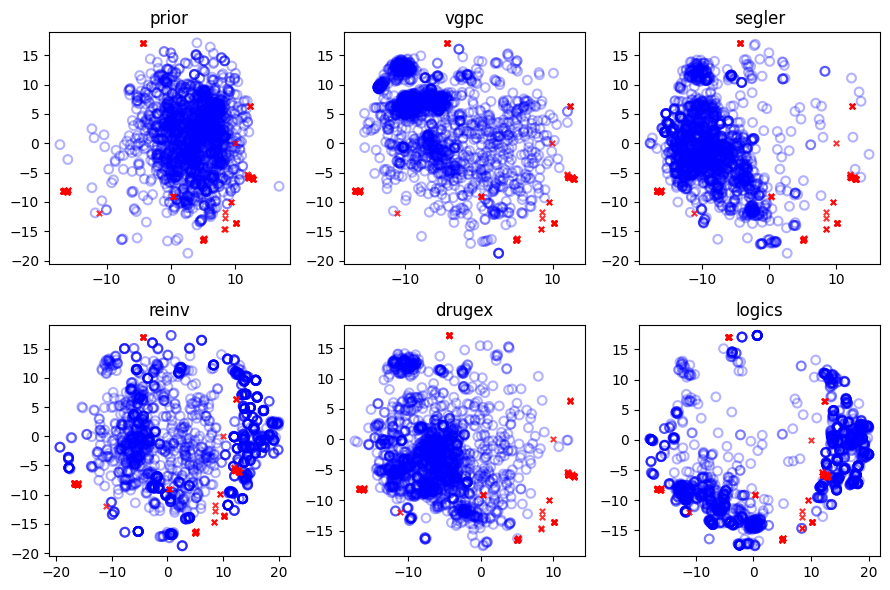

In [12]:
figsize = (9, 6)
fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

for nth in range(num_m):
    row, col = int(nth/num_cols), nth%num_cols   # draw plot at this cell
    gens = vectors_list[nth]
    axes[row,col].scatter(gens[:vis_gensz,0], gens[:vis_gensz,1], **gen_kwarg)
    axes[row,col].scatter(tsa_tsned[:,0], tsa_tsned[:,1], **tsa_kwarg)
    axes[row,col].set_title(model_names[nth])
    
fig.tight_layout()